In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
window_loc = DATA_DIR / 'umap_windows/buckeye/than_when_then_they_them_50.pickle'

In [5]:
words_df = pd.read_pickle(window_loc)

In [6]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
4,25.588546,25.778605,they,"[dh, ey]","[0.0, 0.06714699999999851]","[0.06714699999999851, 0.19005899999999798]",10,4,4,s25,0,o,f,s2501b,16000,"[[3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[3, 23, 38, 44, 47, 47, 44, 36, 20, 8, 0, 1,..."
26,33.108949,33.305837,they,"[dh, ey]","[0.0, 0.08692599999999828]","[0.08692599999999828, 0.19688799999999418]",11,6,6,s25,0,o,f,s2501b,16000,"[[48, 83, 111, 130, 143, 152, 158, 162, 165, 1...","[[[48, 111, 142, 139, 134, 135, 136, 124, 81, ..."
69,48.811535,48.956812,then,"[n, eh, n]","[0.0, 0.018174999999999386, 0.11372099999999818]","[0.018174999999999386, 0.11372099999999818, 0....",2,1,1,s25,0,o,f,s2501b,16000,"[[205, 205, 203, 202, 200, 198, 196, 194, 193,...","[[[205, 199, 141, 98, 153, 150, 127, 113, 117,..."


In [7]:
words_df = words_df[[len(np.shape(i)) != 1 for i in words_df.windows.values]]

In [8]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [9]:
words[:10]

array(['they', 'they', 'they', 'they', 'they', 'they', 'they', 'they',
       'they', 'they'], dtype='<U4')

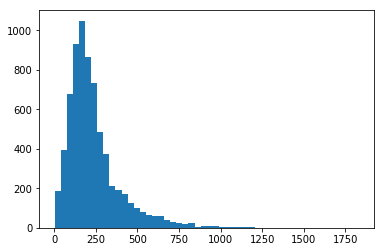

In [10]:
plt.hist(n_windows, bins=50);

In [11]:
rate = 16000

In [12]:
windows = np.vstack((words_df.windows.values))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(1611723, 100, 32)
(1611723, 3200)


In [14]:
cuml_umap = cumlUMAP(min_dist = 0.5)# 
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
ERROR:Call to cuMemcpyHtoD results in CUDA_ERROR_INVALID_VALUE


CudaAPIError: [1] Call to cuMemcpyHtoD results in CUDA_ERROR_INVALID_VALUE

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.0025, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [ ]:
len(np.unique(words))

In [ ]:
pal = sns.color_palette('Set1', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [ ]:
word_pal

In [ ]:
cols = [word_pal[i] for i in words]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.0025, s = 1, color=cols)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])